<a href="https://colab.research.google.com/github/lucabarattini/Trees-Boosting-AppliedML-Project/blob/main/Luca_Barattini_%7C_LB3656_%7C_Applied_Machine_Learning_Assignment_2_%7C_Trees_and_Boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## COMSW4995 - Applied Machine Learning


---


### Luca Barattini - @lb3656:


---


### Project description and goal:
The goal of the project is to explore the intricate power of Boosting methods. We will move beyond the implementation of a single model and investigate how Boosting approaches can improve generalization by correcting residual errors in sequential learners.


---


### Dataset description and problem scoping:
The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y).


---


### Now, let's start by importing our libraries:





In [1]:
import numpy as np
import pandas as pd
import numpy as np, matplotlib.pyplot as plt, math
import seaborn as sns

from matplotlib import cm
from matplotlib.ticker import PercentFormatter


import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score

from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('bank-additional-full.csv', delimiter=";")
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Let's explore the data types and possible null values:

In [3]:
df.info()
print('*'*150)
print(df.isnull().sum())
print('*'*150)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

### No null values with the typical NaN representation but many cateogorical values, let's proceed with a deep-dive on them:

In [4]:
print('Unique values by column:')
print('job         →', df['job'].unique())
print('marital     →', df['marital'].unique())
print('education   →', df['education'].unique())
print('default     →', df['default'].unique())
print('housing     →', df['housing'].unique())
print('loan        →', df['loan'].unique())
print('contact     →', df['contact'].unique())
print('month       →', df['month'].unique())
print('day_of_week →', df['day_of_week'].unique())
print('poutcome    →', df['poutcome'].unique())
print('y           →', df['y'].unique())


Unique values by column:
job         → ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']
marital     → ['married' 'single' 'divorced' 'unknown']
education   → ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']
default     → ['no' 'unknown' 'yes']
housing     → ['no' 'yes' 'unknown']
loan        → ['no' 'yes' 'unknown']
contact     → ['telephone' 'cellular']
month       → ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
day_of_week → ['mon' 'tue' 'wed' 'thu' 'fri']
poutcome    → ['nonexistent' 'failure' 'success']
y           → ['no' 'yes']


### From this code we have seen that our target variable y is categorical (i.e. 'yes' or 'no'). Let's adress this issue immediately and convert into a numerical signal:

In [5]:
df['y'] = (df['y'] == 'yes').astype('int8')  # yes→1, no→0

### Now, let's dive deeper into an EDA for our dataset:

In [6]:
def ensure_cols(df, cols):
    return [c for c in cols if c in df.columns]

b_dark, b_mid, b_light = "#2C7FB8", "#6BAED6", "#BBD7EA"

In [7]:
display(df)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1


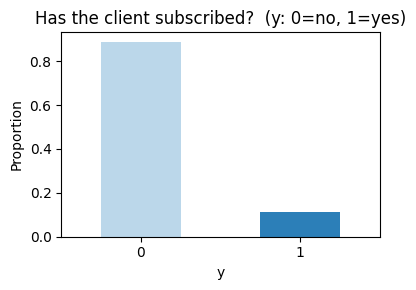

In [8]:
# =========================
# 1) Target Analysis
# =========================
fig, ax = plt.subplots(figsize=(4,3))
(df['y'].value_counts(normalize=True)
   .reindex([0, 1])
   .plot(kind='bar', color=[b_light, b_dark], rot=0, ax=ax))
ax.set_ylabel('Proportion'); ax.set_title('Has the client subscribed?  (y: 0=no, 1=yes)')
plt.tight_layout(); plt.show()


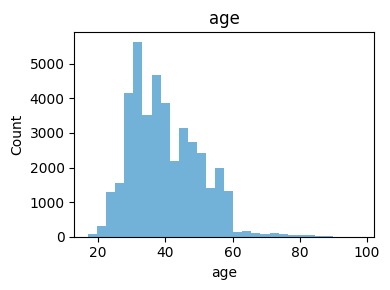

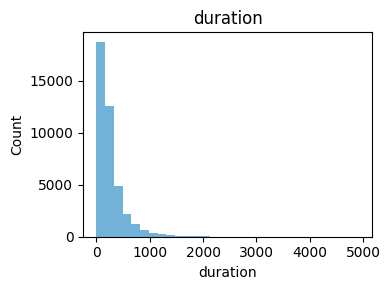

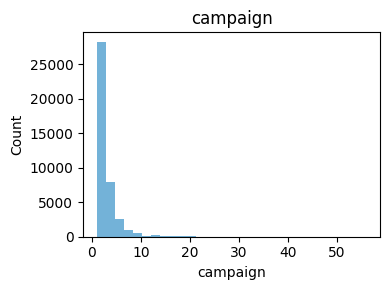

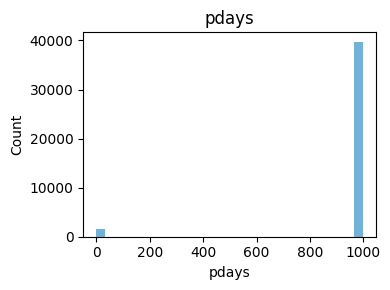

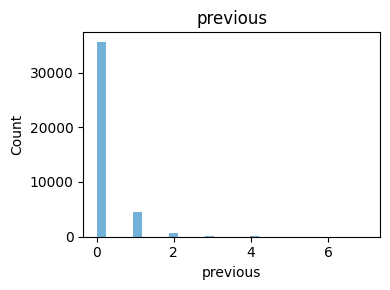

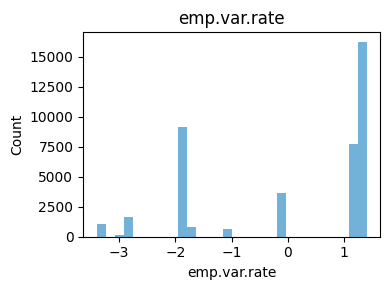

In [ ]:
# =========================
# 2) Numeric histograms
# =========================
num_cols = ensure_cols(df, [
    'age','duration','campaign','pdays','previous',
    'emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed'
])
for col in num_cols:
    fig, ax = plt.subplots(figsize=(4,3))
    df[col].plot(kind='hist', bins=30, color=b_mid, alpha=0.95, ax=ax)
    ax.set_title(col); ax.set_ylabel('Count'); ax.set_xlabel(col)
    plt.tight_layout(); plt.show()

q1 = df[num_cols].quantile(0.25); q3 = df[num_cols].quantile(0.75)
iqr = q3 - q1; lo = q1 - 1.5*iqr; hi = q3 + 1.5*iqr
# =========================
# 2.A.) Creating a summary dataframe and plotting all the numerical variables also in a consolidated
#       histogram view and in a boxplot.
# =========================

summary = pd.DataFrame({
    'skew': df[num_cols].skew(),
    'outlier_%': ((df[num_cols].lt(lo) | df[num_cols].gt(hi)).mean()*100)
}).round(2).sort_values('outlier_%', ascending=False)

print(summary.to_string())

df[num_cols].hist(bins=30, figsize=(12,6))
plt.tight_layout(); plt.show()


df[num_cols].boxplot(vert=False, figsize=(12,5), grid=False)
plt.title('Numeric features – boxplots'); plt.tight_layout(); plt.show()


### Ordering our categorical variable that have an intrisic order:

In [ ]:
orderings = {
    'month':       ['mar','apr','may','jun','jul','aug','sep','oct','nov','dec'],
    'education':   ['illiterate','basic.4y','basic.6y','basic.9y',
                    'high.school','professional.course','university.degree','unknown'],
    'day_of_week': ['mon','tue','wed','thu','fri'],
}

for c, cats in orderings.items():
    if c in df.columns:
        df[c] = pd.Categorical(df[c], categories=cats, ordered=True)


In [ ]:
# =========================
# 3) Categorical: normalized bars
# =========================
cat_cols = ensure_cols(df, [
    'job','marital','education','default','housing','loan',
    'contact','month','day_of_week','poutcome'
])
for col in cat_cols:
    fig, ax = plt.subplots(figsize=(5,3.2))
    (df[col].value_counts(normalize=True)
        .sort_index()
        .plot(kind='bar', color=b_mid, ax=ax))
    ax.set_title(f'{col} (proportion)'); ax.set_ylabel('Proportion'); ax.set_ylim(0,1)
    ax.tick_params(axis='x', rotation=20)
    plt.tight_layout(); plt.show()


In [ ]:
b_dark, b_mid, b_light = "#2C7FB8", "#6BAED6", "#BBD7EA"

cats = df['month'].cat.categories
s = df['month'].value_counts().reindex(cats, fill_value=0)

ax = s.plot(kind='bar', color=b_mid, rot=0, figsize=(6,3), title='Entries per month')
ax.axhline(s.mean(), color=b_dark, linestyle='--', linewidth=1)
ax.set_ylabel('Count'); plt.tight_layout(); plt.show()
print()
print('*'*150)
print()
print(s.astype(int).to_string())

In [ ]:
# =========================
# 4) Absolute correlation heatmap (numeric only)
# =========================
num_for_corr = ensure_cols(df, num_cols + ['y'])  # keep only those present
corr = df[num_for_corr].corr().abs()
fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(corr, cmap='Blues', vmin=0, vmax=1)
ax.set_xticks(range(len(corr.columns))); ax.set_xticklabels(corr.columns, rotation=45, ha='right')
ax.set_yticks(range(len(corr.index)));   ax.set_yticklabels(corr.index)
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        ax.text(j, i, f'{corr.values[i,j]:.2f}', ha='center', va='center', color='black', fontsize=8)
ax.set_title('Absolute Correlation (numeric)'); fig.colorbar(im, ax=ax)
plt.tight_layout(); plt.show()


In [ ]:
# =========================
# 5) y-rate by categorical (stacked bars)
# =========================
cats_for_rate = cat_cols
for col in cats_for_rate:
    tab = pd.crosstab(df[col], df['y'], normalize='index').reindex(columns=[1,0])
    fig, ax = plt.subplots(figsize=(6,3.2))
    tab.plot(kind='bar', stacked=True, color=[b_dark, b_light], ax=ax, legend=True)
    ax.set_title(f'P(y=1) by {col} (stacked)'); ax.set_ylabel('Proportion'); ax.set_ylim(0,1)
    ax.tick_params(axis='x', rotation=25)
    ax.legend(['Deposit','No deposit'], loc='upper left', bbox_to_anchor=(1.02, 1.0),
              frameon=False, title='Outcome')
    plt.tight_layout(); plt.show()

### Feature engineering (numerical values):

In [ ]:
# --- cross-features & flags ---
df['any_loan'] = ((df['housing'] == 'yes') | (df['loan'] == 'yes')).astype('int8')
df['loan_info_missing'] = ((df['housing'] == 'unknown') | (df['loan'] == 'unknown')).astype('int8')

df['is_student']    = (df['job'] == 'student').astype('int8')
df['is_retired']    = (df['job'] == 'retired').astype('int8')
df['is_unemployed'] = (df['job'] == 'unemployed').astype('int8')

# --- months: include all listed; create a quarter feature ---
month_order = ['mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
to_qtr = {
    'mar':'Q1', 'apr':'Q2',
    'may':'Q2','jun':'Q2',
    'jul':'Q3','aug':'Q3','sep':'Q3',
    'oct':'Q4','nov':'Q4','dec':'Q4'
}
df['month_qtr'] = df['month'].map(to_qtr)


In [ ]:
# =========================
# PDAYS engineering (from pdays)
# =========================

p = df['pdays']

df['never_contacted']  = (p == 999).astype('int8')
df['days_since_prev_contact_shift_1']     = np.where(p == 999, 0, p + 1).astype('int16')

# Creating two features to indicate whether the lead has ever been contacted and
# also how many times he/she got contacted during this campaing
for c in ['previous','campaign']:
    df[f'{c}_greater_than_0'] = (df[c] > 0).astype('int8')

# Creating a clip on the 99th quantile upper bound.
caps = df[['previous','campaign']].quantile(0.99)
df['previous'] = df['previous'].clip(upper=float(caps['previous']))
df['campaign_clip'] = df['campaign'].clip(upper=float(caps['campaign']))

# Scaling to a log1(P) value to capture better signal over noise.
df['previous_log1p'] = np.log1p(df['previous'])
df['campaign_log1p'] = np.log1p(df['campaign'])

df.drop(columns=['pdays'], inplace=True)

In [ ]:
# =========================
# Tiny EDA on days_since_prev_contact_shift_1
# =========================
num_cols = ensure_cols(df, [
    'days_since_prev_contact_shift_1'
])

q1 = df[num_cols].quantile(0.25); q3 = df[num_cols].quantile(0.75)
iqr = q3 - q1; lo = q1 - 1.5*iqr; hi = q3 + 1.5*iqr

summary = pd.DataFrame({
    'skew': df[num_cols].skew(),
    'outlier_%': ((df[num_cols].lt(lo) | df[num_cols].gt(hi)).mean()*100)
}).round(2).sort_values('outlier_%', ascending=False)

print(summary.to_string())

df[num_cols].boxplot(vert=False, figsize=(12,5), grid=False)
plt.title('Numeric features – boxplots'); plt.tight_layout(); plt.show()


### Categorical features `value_counts()` analysis and feature renaming:

In [ ]:
# --- 3) % of 'unknown' per feature + blue bar chart wrapped on 2 lines -------
cats = ['job','marital','education','default','housing','loan']
present = [c for c in cats if c in df.columns]

unk_cnt = df[present].eq('unknown').sum()
unk_pct = (df[present].eq('unknown').mean()*100)

order = unk_pct.sort_values(ascending=False).index.tolist()

for c in order:
    vc = df[c].value_counts(dropna=False)
    tot = int(vc.sum())
    parts = [f"{str(k)}={int(v)} ({v*100/tot:.1f}%)" for k, v in vc.items()]
    print(f"{c:<12} (n={tot}) → " + " | ".join(parts))

In [ ]:
ncols = math.ceil(len(order)/2) or 1
fig, axes = plt.subplots(2, ncols, figsize=(4*ncols, 6), sharey=True); axes = axes.ravel()
for i, c in enumerate(order):
    p = unk_pct[c]
    axes[i].bar(['unknown','other'], [p, 100-p], color=[plt.cm.Blues(0.85), plt.cm.Blues(0.55)])
    axes[i].set_title(f"{c} ({p:.1f}%)"); axes[i].set_ylim(0,100); axes[i].grid(axis='y', alpha=0.2)
for j in range(i+1, len(axes)): fig.delaxes(axes[j])
fig.suptitle('Unknown vs Other (%), sorted by Unknown'); plt.tight_layout(); plt.show()

### From this code, we can observe that in most of our categorical features we have the presence of the category 'uknown', therefore, we must dive deeper.


---


### Over the next parts, we will analyse feature by feature. Let's start with Default:


In [ ]:
df['default'] = df['default'].replace({'yes':'unknown'})
df = df.join(pd.get_dummies(df['default'], prefix='default', drop_first=False, dtype='int8')) \
       .drop(columns='default')

### Now let's move over to *Education*:

In [ ]:
edu_order = {
    'illiterate':0,'basic.4y':1,'basic.6y':2,'basic.9y':3,
    'high.school':4,'professional.course':5,'university.degree':6,
    'unknown':3  # put unknown at mid-rank
}
df['education_unknown'] = (df['education'] == 'unknown').astype('int8')
df['education_ord'] = df['education'].map(edu_order).astype('int8')
df.drop(columns=['education'], inplace=True)

### Housing:
This variable showcase `yes=21576 (52.4%) | no=18622 (45.2%) | unknown=990 (24%) `, therefore, we can handle the Unknown values by expanding them with the `pd.get_dummies` method.

In [ ]:
dummies = pd.get_dummies(df['housing'], prefix='housing', drop_first=False, dtype='int8')
df.drop(columns=['housing'], inplace=True)
df = df.join(dummies)

### Job Feature:

In [ ]:
# First, we fix a typo in one of the job values (i.e. 'admin.' to -> 'admin')

df['job'] = df['job'].replace({'admin.':'admin'})
print('job         →', df['job'].unique())

In [ ]:
df = df.join(pd.get_dummies(df.pop('job'), prefix='job', drop_first=False, dtype='int8'))

### Loan & Marital:

In [ ]:
df = df.join(pd.get_dummies(df.pop('loan'), prefix='loan', drop_first=False, dtype='int8'))

df = df.join(pd.get_dummies(df.pop('marital'), prefix='marital', drop_first=False, dtype='int8'))

### Now, let's move over to the last four categorical features and analyse how to handle them:

In [ ]:
for c in ['contact','month','day_of_week', 'poutcome']:
    vc = df[c].value_counts()
    tot = int(vc.sum())
    print(f"\n{c} (n={tot})")
    print((vc.astype(str) + " (" + (vc*100/tot).round(1).astype(str) + "%)").to_string())

### Let's perform OneHot Econding for such features `('contact','day_of_week', 'poutcome', 'month_qtr')`:
### For the latter one, we will first create a new feature named 'prev_contacted' indicating whether that person has already been contacted or not. Then, create the OHE representation.

In [ ]:
df = df.join(pd.get_dummies(df.pop('contact'),     prefix='contact', dtype='int8'))
df = df.join(pd.get_dummies(df.pop('day_of_week'), prefix='dow',     dtype='int8'))
df = df.join(pd.get_dummies(df.pop('month_qtr'), prefix='quarter_ID',dtype='int8'))
df['prev_contacted'] = (df['poutcome'] != 'nonexistent').astype('int8')
df = df.join(pd.get_dummies(df.pop('poutcome'), prefix='previous_outcome',dtype='int8'))

### Now that we have gained a better understanding of our categorical features, we can move on towards numerical:

In [ ]:
print('Numerical values by column:')

display(df.describe())


In [ ]:
df = df.rename(columns={
    'emp.var.rate': 'employment_variation_rate',
    'cons.price.idx': 'consumer_price_index',
    'cons.conf.idx': 'consumer_confidence_index',
    'euribor3m': 'euribor_3_month_rate',
    'nr.employed': 'number_of_employees',
    'previous': 'n_previous_contacts'
})

### Before proceeding, we need to remove the `Duration` column as advised also in the dataset description. We'll do this for a dual reason: when forecasting `y`, we don't know in advance how much the call lasted and, if we were to keep it in the training set, then, we would be shaping on noise rather than signal.

In [ ]:
df = df.drop(columns=['duration'])

### Train-Validate-Test Split:

Since our data is following a temporal series (march:dec) we cannot split with the classic sklearn train_test split due to a concrete data leak risk. Therefore we are going to conduce a small EDA to assess whether a 6-2-2 scheme following the temporal distribution would make more sense.

In [ ]:
# Plotting style for charts
plt.style.use('fivethirtyeight')
b_dark, b_mid, b_light = "#2C7FB8", "#6BAED6", "#BBD7EA"

In [ ]:
train_m = ['mar','apr','may','jun','jul','aug']
val_m   = ['sep','oct']
test_m  = ['nov','dec']
m_train = df['month'].isin(train_m)
m_val   = df['month'].isin(val_m)
m_test  = df['month'].isin(test_m)

df = df.join(pd.get_dummies(df.pop('month'), prefix='month', dtype='int8'))

X = df.drop(columns=['y']); y = df['y']
X_train, y_train = X[m_train], y[m_train]
X_val,   y_val   = X[m_val],   y[m_val]
X_test,  y_test  = X[m_test],  y[m_test]

print(" Train months:", train_m, '\n', "Validation months:", val_m, "\n","Testing momths:", test_m)

### Now we can perform OHE on the `month` column and finally drop it:

In [ ]:
# --- 2) quick EDA ---
rates = pd.Series({'Train': y_train.mean(), 'Val': y_val.mean(), 'Test': y_test.mean()}).reindex(['Train','Val','Test']).astype(float)
sizes = pd.Series({'Train': len(y_train),   'Val': len(y_val),   'Test': len(y_test)}).reindex(rates.index)

fig, ax = plt.subplots(figsize=(6,4))
rates.plot(kind='bar', color=b_mid, edgecolor=b_dark, rot=0, ax=ax)
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.set_ylim(0, 1); ax.set_ylabel('Deposit rate'); ax.set_title('Deposit rate by split')
ax.grid(axis='y', alpha=0.2)

for i, (split, val) in enumerate(rates.items()):
    ax.text(i, val + 0.02, f"{val:.1%}\n(n={sizes[split]})", ha='center', va='bottom', fontsize=9)

plt.tight_layout(); plt.show()

In [ ]:
# --- 3) preprocessing (no categoricals → passthrough) ---
num_cols = X_train.columns.tolist()
preprocess = 'passthrough'

In [ ]:
# --- 4) Baseline Decision Tree (Gini) ---
dt = Pipeline([
    ('prep', preprocess),
    ('clf', DecisionTreeClassifier(criterion='gini', random_state=42))
])

display(X_train)

dt.fit(X_train, y_train)
print(f"Baseline DT | train acc: {dt.score(X_train,y_train):.3f} | val acc: {dt.score(X_val,y_val):.3f}")

# --- 5) Hyperparameter tuning (same as before) ---
param_grid = {
    'clf__max_depth': [None, 4, 6, 8, 10, 12],
    'clf__min_samples_split': [2, 20, 100],
    'clf__ccp_alpha': [0.0, 1e-4, 1e-3, 1e-2],
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(dt, param_grid=param_grid, cv=cv, scoring='accuracy', n_jobs=-1, refit=True)
grid.fit(X_train, y_train)

best_dt = grid.best_estimator_
print("Best params:", grid.best_params_)
print("Best CV acc:", grid.best_score_)
print("Val acc    :", best_dt.score(X_val,  y_val))
print("Test acc   :", best_dt.score(X_test, y_test))

In [ ]:
depths = [1, 2, 3, 4, 6, 8, 10, 12, None]
tr, va = [], []
for d in depths:
    clf = DecisionTreeClassifier(criterion='gini', max_depth=d, random_state=42)
    clf.fit(X_train, y_train)
    tr.append(clf.score(X_train, y_train))
    va.append(clf.score(X_val,   y_val))

plt.figure(figsize=(6,3))
plt.plot([str(d) for d in depths], tr, marker='o', label='Train')
plt.plot([str(d) for d in depths], va, marker='o', label='Validation')
plt.xlabel('max_depth'); plt.ylabel('Accuracy')
plt.title('Decision Tree: under/overfitting'); plt.legend(); plt.tight_layout(); plt.show()

In [ ]:
# Fit an unpruned tree to get the pruning path, then sweep alphas
clf0 = DecisionTreeClassifier(criterion='gini', random_state=42)
clf0.fit(X_train, y_train)
path = clf0.cost_complexity_pruning_path(X_train, y_train)
alphas = path.ccp_alphas

tr, va = [], []
for a in alphas:
    clf = DecisionTreeClassifier(criterion='gini', ccp_alpha=a, random_state=42)
    clf.fit(X_train, y_train)
    tr.append(clf.score(X_train, y_train))
    va.append(clf.score(X_val,   y_val))

plt.figure(figsize=(5,3.2))
plt.plot(alphas, tr, label='Train'); plt.plot(alphas, va, label='Validation')
plt.xlabel('ccp_alpha'); plt.ylabel('Accuracy'); plt.title('Pruning path')
plt.legend(); plt.tight_layout(); plt.show()

# Choose alpha with best val accuracy, refit on train, evaluate on test
best_a = alphas[int(np.argmax(va))]
dt_pruned = DecisionTreeClassifier(criterion='gini', ccp_alpha=best_a, random_state=42)
dt_pruned.fit(X_train, y_train)
print(f"Pruned (alpha={best_a:.4g}) | train: {dt_pruned.score(X_train,y_train):.3f} | "
      f"val: {dt_pruned.score(X_val,y_val):.3f} | test: {dt_pruned.score(X_test,y_test):.3f}")


In [ ]:
# Fit an unpruned tree to get the pruning path, then sweep alphas
clf0 = DecisionTreeClassifier(criterion='gini', random_state=42)
clf0.fit(X_train, y_train)
path = clf0.cost_complexity_pruning_path(X_train, y_train)
alphas = path.ccp_alphas

tr, va = [], []
for a in alphas:
    clf = DecisionTreeClassifier(criterion='gini', ccp_alpha=a, random_state=42)
    clf.fit(X_train, y_train)
    tr.append(clf.score(X_train, y_train))
    va.append(clf.score(X_val,   y_val))

plt.figure(figsize=(5,3.2))
plt.plot(alphas, tr, label='Train'); plt.plot(alphas, va, label='Validation')
plt.xlabel('ccp_alpha'); plt.ylabel('Accuracy'); plt.title('Pruning path')
plt.legend(); plt.tight_layout(); plt.show()

# Choose alpha with best val accuracy, refit on train, evaluate on test
best_a = alphas[int(np.argmax(va))]
dt_pruned = DecisionTreeClassifier(criterion='gini', ccp_alpha=best_a, random_state=42)
dt_pruned.fit(X_train, y_train)
print(f"Pruned (alpha={best_a:.4g}) | train: {dt_pruned.score(X_train,y_train):.3f} | "
      f"val: {dt_pruned.score(X_val,y_val):.3f} | test: {dt_pruned.score(X_test,y_test):.3f}")


In [ ]:
depth = 6  # pick a reasonable depth from the plot
mins = [2, 10, 20, 50, 100, 200]
for m in mins:
    clf = DecisionTreeClassifier(criterion='gini', max_depth=depth, min_samples_split=m, random_state=42)
    clf.fit(X_train, y_train)
    print(f"depth={depth:<2} | min_samples_split={m:<3} | "
          f"train={clf.score(X_train,y_train):.3f} | val={clf.score(X_val,y_val):.3f}")


In [ ]:
baseline_dt = Pipeline(steps=dt.steps)  # copy your earlier baseline pipeline
baseline_dt.set_params(clf__max_depth=None, clf__min_samples_split=2, clf__ccp_alpha=0.0)
baseline_dt.fit(X_train, y_train)

print(f"Baseline DT  | train: {baseline_dt.score(X_train,y_train):.3f} | "
      f"val: {baseline_dt.score(X_val,y_val):.3f} | test: {baseline_dt.score(X_test,y_test):.3f}")
print(f"Tuned DT     | train: {best_dt.score(X_train,y_train):.3f} | "
      f"val: {best_dt.score(X_val,y_val):.3f} | test: {best_dt.score(X_test,y_test):.3f}")


In [ ]:
df.info()